# Applying normal Timewise PCA

In [ ]:
import seaborn as sns
import os
import pandas as pd
sns.set_theme(style="ticks")

In [ ]:
# Load segmented data
def load_segmented_data(data_folder="data/data_segment", event_name=None):
    """
    Load segmented CSV data.

    Parameters:
    - data_folder (str): Folder where the segmented .csv files are stored.
    - event_name (str or None): Name of the event to load. If None, loads all CSV files.

    Returns:
    - pd.DataFrame: Loaded dataframe with all data concatenated if loading all events.
    """
    if event_name is not None:
        # Load one specific event csv
        file_path = os.path.join(data_folder, f"segment_around_{event_name}.csv")
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"No data found for event '{event_name}' at {file_path}")
        df = pd.read_csv(file_path)
        print(f"Loaded data for event '{event_name}' from {file_path}.")
        return df
    else:
        # Load all csv files in the folder that match pattern 'segment_around_*.csv'
        all_files = [f for f in os.listdir(data_folder) if f.startswith("segment_around_") and f.endswith(".csv")]
        if not all_files:
            raise FileNotFoundError(f"No segmented CSV files found in folder {data_folder}")

        dfs = []
        for file in all_files:
            path = os.path.join(data_folder, file)
            df_temp = pd.read_csv(path)
            # Optionally add a column indicating source event, parsed from filename
            event_from_file = file.replace("segment_around_", "").replace(".csv", "")
            df_temp['EventName'] = event_from_file
            dfs.append(df_temp)
        df_all = pd.concat(dfs, ignore_index=True)
        print(f"Loaded and concatenated {len(all_files)} segmented event files from {data_folder}.")
        return df_all

In [ ]:
# Load single event:
df_single_event = load_segmented_data(data_folder="data/data_segment", event_name="StagEventNew")
df_single_event
# Load all events:
# df_all = load_segmented_data(data_folder="data/data_segment")

In [ ]:
df_single_event['uid'].nunique()

In [114]:
df_single_event.columns

Index(['timestamp_REF', 'uid', 'dataset', 'city_section',
       'ExperimentalCondition', 'UnixTimeStamp', 'TobiiTimeStamp',
       'RightEyeIsBlinkingWorld', 'RightEyeIsBlinkingLocal',
       'LeftEyeIsBlinkingWorld', 'LeftEyeIsBlinkingLocal', 'HmdPosition.x',
       'HmdPosition.y', 'HmdPosition.z', 'NoseVector.x', 'NoseVector.y',
       'NoseVector.z', 'EyePosWorldCombined.x', 'EyePosWorldCombined.y',
       'EyePosWorldCombined.z', 'EyeDirWorldCombined.x',
       'EyeDirWorldCombined.y', 'EyeDirWorldCombined.z',
       'EyePosLocalCombined.x', 'EyePosLocalCombined.y',
       'EyePosLocalCombined.z', 'EyeDirLocalCombined.x',
       'EyeDirLocalCombined.y', 'EyeDirLocalCombined.z', 'ObjectName_1',
       'ObjectName_2', 'ObjectName_3', 'ObjectName_4', 'ObjectName_5',
       'HitObjectPosition.x_1', 'HitObjectPosition.x_2',
       'HitObjectPosition.x_3', 'HitObjectPosition.x_4',
       'HitObjectPosition.x_5', 'HitObjectPosition.y_1',
       'HitObjectPosition.y_2', 'HitObjectPositio

# 1. Visualize variables

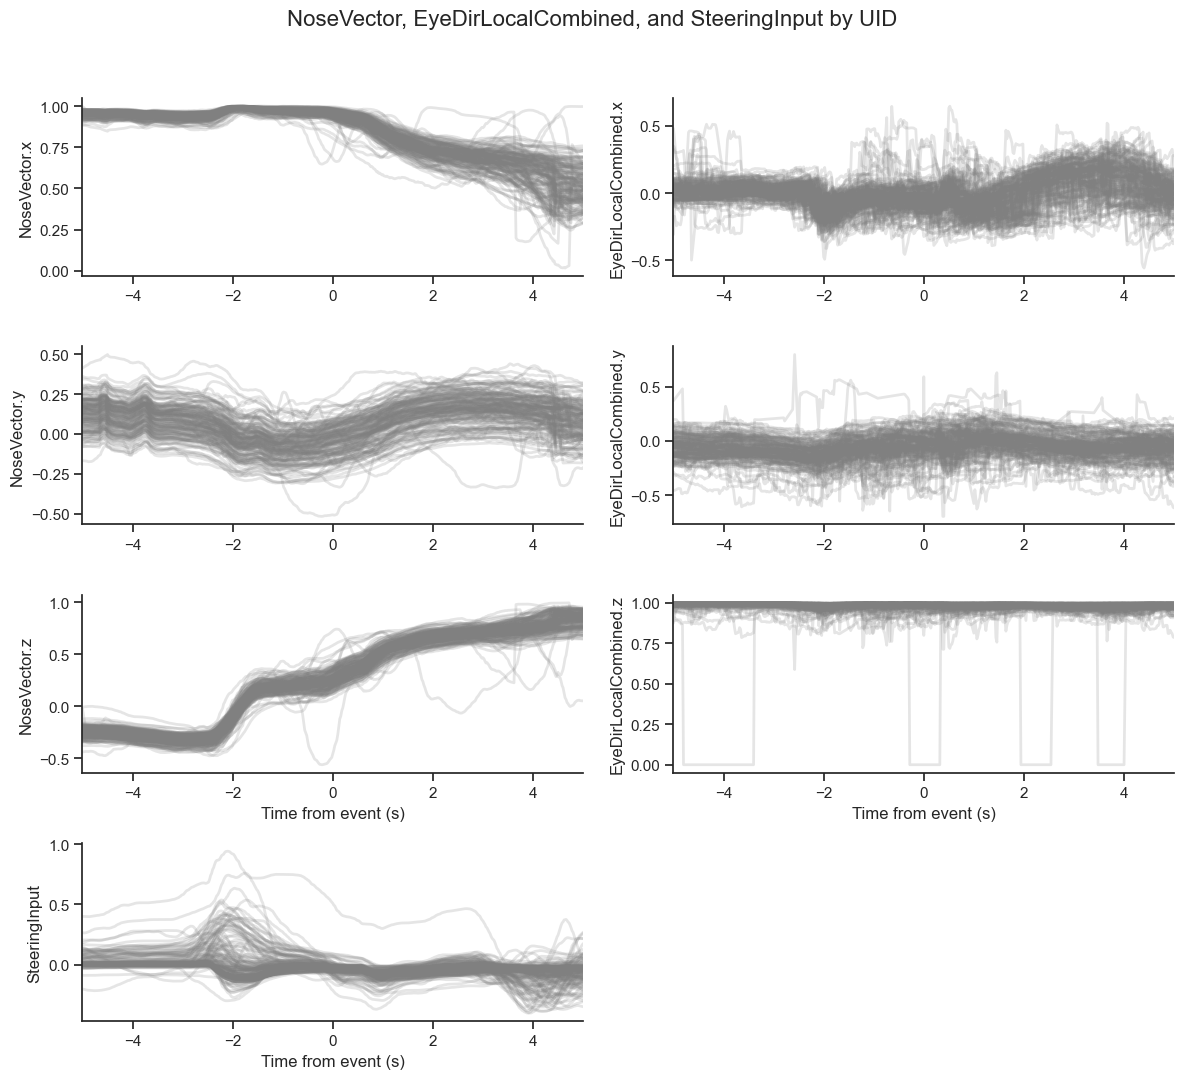

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns  # For despine

def plot_vectors(df, uid_col='uid'):
    """
    Plot NoseVector and EyeDirLocalCombined components in a 4x2 subplot figure,
    showing individual lines per uid,
    despined axes with white grid and x-limits set to time_from_event range.
    The last row's left subplot is reserved for SteeringInput.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the columns:
        ['uid', 'time_from_event',
         'NoseVector.x', 'NoseVector.y', 'NoseVector.z',
         'EyeDirLocalCombined.x', 'EyeDirLocalCombined.y', 'EyeDirLocalCombined.z',
         'SteeringInput']
    - uid_col (str): Column name representing unique identifiers (default 'uid').
    """

    fig, axs = plt.subplots(4, 2, figsize=(12, 11), sharex=False)
    fig.suptitle("NoseVector, EyeDirLocalCombined, and SteeringInput by UID", fontsize=16)

    unique_uids = df[uid_col].unique()

    left_cols = ['NoseVector.x', 'NoseVector.y', 'NoseVector.z']
    right_cols = ['EyeDirLocalCombined.x', 'EyeDirLocalCombined.y', 'EyeDirLocalCombined.z']

    color = 'gray'
    alpha = 0.2
    linewidth = 2

    x_min = df['time_from_event'].min()
    x_max = df['time_from_event'].max()

    # Plot NoseVector and EyeDirLocalCombined (top 3 rows)
    for uid in unique_uids:
        df_uid = df[df[uid_col] == uid].sort_values('time_from_event')

        for i, col in enumerate(left_cols):
            axs[i, 0].plot(df_uid['time_from_event'], df_uid[col],
                           color=color, alpha=alpha, linewidth=linewidth)

        for i, col in enumerate(right_cols):
            axs[i, 1].plot(df_uid['time_from_event'], df_uid[col],
                           color=color, alpha=alpha, linewidth=linewidth)

        # SteeringInput in last row, left column only
        axs[3, 0].plot(df_uid['time_from_event'], df_uid['SteeringInput'],
                       color=color, alpha=alpha, linewidth=linewidth)

    # Set labels, limits, grids, and despine for upper 3 rows
    for i, col in enumerate(left_cols):
        ax = axs[i, 0]
        ax.set_ylabel(col)
        ax.set_xlim(x_min, x_max)
        # ax.grid(True, color='white', linestyle='-', linewidth=2, alpha=1)
        sns.despine(ax=ax, top=True, right=True)

    for i, col in enumerate(right_cols):
        ax = axs[i, 1]
        ax.set_ylabel(col)
        ax.set_xlim(x_min, x_max)
        # ax.grid(True, color='white', linestyle='-', linewidth=1, alpha=0.7)
        sns.despine(ax=ax, top=True, right=True)

    # SteeringInput axis formatting (last row, left column)
    ax_steering = axs[3, 0]
    ax_steering.set_ylabel('SteeringInput')
    ax_steering.set_xlabel('Time from event (s)')
    ax_steering.set_xlim(x_min, x_max)
    ax_steering.grid(True, color='white', linestyle='-', linewidth=2, alpha=1)
    sns.despine(ax=ax_steering, top=True, right=True)

    # Turn off unused subplot (last row, right column)
    axs[3, 1].axis('off')

    # Set x-labels for last row in left column (done above) and also for upper right col (optional)
    for ax in axs[2, :]:
        ax.set_xlabel('Time from event (s)')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage:
plot_vectors(df_single_event, uid_col='uid')

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
sns.scatterplot(x=df_single_event['time_from_event'], y=df_single_event['SteeringInput'], label='SteeringInput', color='gray', alpha=0.1, s=5, ax=axs)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)

sns.lineplot(data=df_single_event, x='time_from_event', y='NoseVector.x',label='NoseVector.x', color='gray', alpha=0.5, linewidth=1, hue="uid", ax=axs, legend=False)
# sns.lineplot(data=df_single_event, x='time_from_event', y='NoseVector.x', color='gray', alpha=0.5, linewidth=1, hue="ExperimentalCondition", ax=axs, legend=True)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)

plt.plot(df_single_event['time_from_event'].head(1000), df_single_event['NoseVector.x'].head(1000), label='NoseVector.x', color='gray', alpha=1, linewidth=1)


# Apply PCA

In [126]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
import dask.array as da
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
import gc
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
plt.style.use('ggplot')

In [127]:
# Map each condition to a float number
# label_mapping = {'True': 1, 'False': 0}
# # with outliers
# df_single_event.loc[:,'SuccessfulCompletion'] = df_single_event['SuccessfulCompletionState'].map(label_mapping)
# df_single_event

## Useful functions

In [149]:
# Mapping of old labels to new labels
def map_labels(labels, label_mapping):
    """
    Maps each label in the given list using the provided mapping dictionary.

    Args:
        labels (list): List of original labels.
        label_mapping (dict): Mapping dictionary for label replacement.

    Returns:
        list: New list with mapped labels.
    """
    return [label_mapping.get(label, label) for label in labels]

# Define your label mapping (you can modify this as needed)
custom_mapping = {
    'EyeDirLocalCombined.x': 'Eye Horizontal',
    'EyeDirLocalCombined.y': 'Eye Vertical',
    'NoseVector.x': 'Head Horizontal',
    'NoseVector.y': 'Head Vertical',
    'SteeringInput': 'Steering',
    'ExperimentalCondition ': 'Condition',
}

In [150]:
def biplot(score, coef, eigenvalues,
           labels=None,
           colors=None,
           explained_variance=None,
           vector_colors=None,
           scaled=None,
           vector_linewidth=None):
    plt.rcParams.update({'font.size': 20})
    # Apply 90-degree rotation matrix to `score` and `coef`
    # rotation_matrix = np.array([[0, -1], [1, 0]])
    # Rotate the first two components of the scores
    # score = np.dot(score[:, :2], rotation_matrix)
    # Rotate the first two components of the loadings
    # coef = np.dot(coef[:, :2], rotation_matrix)
    xs = score[:, 0]
    ys = score[:, 1]
    n = coef.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    padding= 1.2 # 20% padding for axis and vector scaling
    padding_text = 1.1 # 10 % padding for text
    xlims = padding * np.max(np.abs(xs))
    ylims = padding * np.max(np.abs(ys))
    if colors is None:  # If no color information, plot all points orange
        plt.scatter(xs, ys, s=80, color='gray', alpha=0.5,edgecolor='gray')
        # plt.scatter(xs, ys, s=80, color='orange')
    else:  # If color information is given, plot points with corresponding colors
        # plt.scatter(xs * scalex, ys * scaley, s=80, color=colors, alpha=0.5)
        plt.scatter(xs, ys, s=80, color=colors, alpha=0.5,edgecolor=colors)
    plt.xlim(-xlims * padding,xlims * padding)
    plt.ylim(-ylims* padding,ylims* padding)

    # Adjust the number of labels to match the number of coefficients
    original_labels = labels[:n]

    # Call the function to get the new mapped labels
    labels = map_labels(original_labels, custom_mapping)

    # Draw principal component vectors as arrows
    for i in range(n):
        # Calculate arrow end point (arrow head)
        arrow_end_x = xlims * coef[i, 0]
        arrow_end_y = ylims * coef[i, 1]
        if scaled:
            # Draw the arrow starting from the origin (0, 0) to the arrow head
            plt.arrow(0, 0, arrow_end_x, arrow_end_y, color=vector_colors[i], alpha=1, linewidth=vector_linewidth,length_includes_head=True,head_length=0.1,head_width=0.1,overhang=0)
        else:
            plt.arrow(0, 0, arrow_end_x, arrow_end_y, color=vector_colors[i], alpha=1, linewidth=vector_linewidth,length_includes_head=True,head_length=0.7,head_width=0.7,overhang=0)
    # Position the label above the arrow head
        if labels is not None:
            if arrow_end_y > 0:
                va='bottom'
            else:
                va='top'
            # Annotate the point with text (you can customize the text as needed)
            plt.text(arrow_end_x * padding_text, arrow_end_y * padding_text,
                     f"{labels[i]}\n({coef[i, 0]:.2f}, {coef[i, 1]:.2f})",color='black',ha='center', va=va,fontdict=dict(fontsize=14), bbox=dict(facecolor='white', alpha=0.0001, edgecolor='white'))
    # Write first two eigenvalues
    # plt.text(-ylims + padding_text, -xlims * padding_text, "Eigenvalues:\n {:.2f}, {:.2f}".format(*eigenvalues),ha='left', va='bottom', fontsize=10)
    # Write all eigenvalues
    # plt.text(-ylims + 0.5, -xlims + 0.5, "Eigenvalues:\n " + ", ".join(f"{val:.2f}" for val in eigenvalues), ha='left', va='bottom', fontsize=10)

    # Set fixed axis limits
    ax = plt.gca()
    fixed_x_min, fixed_x_max = -xlims, xlims  # Your specified x limits
    fixed_y_min, fixed_y_max = -ylims, ylims  # Your specified y limits

    # Set the fixed limits
    plt.xlim(fixed_x_min, fixed_x_max)
    plt.ylim(fixed_y_min, fixed_y_max)

    # Hide all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Parameters for arrows
    arrow_length = 0.15  # Size of the arrowhead
    arrow_linewidth = 2.5

    # Create y-axis arrow (vertical) ON THE LEFT SPINE
    #  Start at bottom left corner
    ax.arrow(fixed_x_min +arrow_length, fixed_y_min+arrow_length,
             0, fixed_y_max - (fixed_y_max/2.5),  # Go up to max - arrowhead space
             head_width=arrow_length, head_length=arrow_length,
             fc='black', ec='black', linewidth=arrow_linewidth,
             length_includes_head=True)

    # Create x-axis arrow (horizontal) ON THE BOTTOM SPINE
    # Start at bottom left corner
    ax.arrow(fixed_x_min +arrow_length, fixed_y_min+arrow_length,
             fixed_x_max - (fixed_x_max/2.5), 0,  # Go right to max - arrowhead space
             head_width=arrow_length, head_length=arrow_length,
             fc='black', ec='black', linewidth=arrow_linewidth,
             length_includes_head=True)
    # Hide tick parameters
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove standard labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add custom positioned labels
    # X-axis label - at the start of the x-axis arrow
    ax.text(fixed_x_min + 1.5, fixed_y_min - 0.1,  # Position just below the arrow end
            "PC{} ({:.1f}%)".format(1, explained_variance[0] * 100),
            fontsize=18, ha='right', va='top')

    # Y-axis label - at the start of the y-axis arrow
    ax.text(fixed_x_min + 0.02, fixed_y_min + 0.6,  # Position to the left of arrow end
            "PC{} ({:.1f}%)".format(2, explained_variance[1] * 100),
            fontsize=18, ha='right', va='bottom', rotation=90)

    # Add a legend for the colors if provided
    if colors is not None:
        legend_elements = [
            Line2D([0], [0],
                   marker='o',
                   color='w',
                   markerfacecolor='#2A586E',
                   markersize=12,
                   label='Manual',
                   alpha=0.8),
            Line2D([0], [0],
                   marker='o',
                   color='w',
                   markerfacecolor='#cc2936',
                   markersize=12,
                   label='Autonomous',
                   alpha=0.8)
        ]
        plt.legend(handles=legend_elements, fontsize=16)
    # plt.tight_layout()

In [151]:
def get_pca_var(pca, subset_scaled, feature_names):
    # Validate input types
    if not isinstance(pca, PCA):
        raise TypeError("Expected a PCA object from sklearn.decomposition.PCA")

    # Compute coordinates
    coords = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Compute correlations
    # Since we're using standardized data:
    cor = coords / np.std(subset_scaled, axis=0)

    # Compute cos2 (squared loadings or cosine similarity)
    cos2 = np.square(cor)

    # Compute contributions
    total_variance = np.sum(pca.explained_variance_)
    contrib = (cos2 * 100 * pca.explained_variance_) / total_variance

    # Create dataframes with feature names as the index
    coord_df = pd.DataFrame(coords, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    cor_df = pd.DataFrame(cor, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    cos2_df = pd.DataFrame(cos2, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    contrib_df = pd.DataFrame(contrib, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

    return {
        'coord': coord_df,
        'cor': cor_df,
        'cos2': cos2_df,
        'contrib': contrib_df
    }

In [152]:
from matplotlib.patches import Circle
from matplotlib import colors as mcolors

def plot_cosine_similarity(cos2_df, title='', time_point='', save=False):
    # Extract feature names directly from the DataFrame index
    feature_names = cos2_df.index

    max_cos2_value = 1  # color bar maximum limit
    # Create a custom colormap from white to #A2530E
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "#A2530E"])

    features, components = cos2_df.shape
    fig, ax = plt.subplots(figsize=(10, 8))
    if len(feature_names) > 10:
        num_fontsize = 10
    num_fontsize = 12
    ax.set_title(title, fontsize=18)

    # Plot each circle and add annotations
    for i in range(features):
        for j in range(components):
            value = cos2_df.iloc[i, j]
            color = cmap(value / max_cos2_value)  # Normalize the color
            circle = Circle((j, i), radius=np.sqrt(value) * 0.5, color=color, fill=True)
            ax.add_artist(circle)

            # Annotate the cos2 value at the center of the circle
            ax.text(
                j, i, f'{value:.2f}',
                color='lightgray',
                ha='center', va='center',
                fontsize=num_fontsize,  # Adjust font size for readability
            )

    # Setup axis limits and labels
    ax.set_xlim(-0.5, components - 0.5)
    ax.set_ylim(-0.5, features - 0.5)
    ax.set_xticks(np.arange(components))
    ax.set_yticks(np.arange(features))
    ax.set_xticklabels([f'PC{i+1}' for i in range(components)], rotation=0)
    ax.set_yticklabels(feature_names)
    ax.set_aspect('equal', 'box')

    # Add grid lines for clarity
    ax.hlines(np.arange(-0.5, features), xmin=-0.5, xmax=components - 0.5, color='grey', lw=0.5)
    ax.vlines(np.arange(-0.5, components), ymin=-0.5, ymax=features - 0.5, color='grey', lw=0.5)

    # Set outer border to gray by modifying the spines
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')
        spine.set_linewidth(0.5)

    # Add a color bar on the right
    norm = mcolors.Normalize(vmin=0, vmax=max_cos2_value)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04, label='$Cos^2$')

    # Increase the number of ticks on the color bar for better granularity
    num_ticks = 6
    cbar.set_ticks(np.linspace(0, max_cos2_value, num_ticks))
    cbar.set_ticklabels([round(val, 2) for val in np.linspace(0, max_cos2_value, num_ticks)])
    cbar.outline.set_visible(True)
    plt.tight_layout()
    # if save:
    #     plt.savefig(f"plots/pca_new/timeplots/pca_cos2_{event}_{time_point}_{''.join(map(str, feature_names))}.pdf", dpi=1200)
    plt.show()

In [236]:
# Directories to save results
# Ensure os is imported to work with the file system
import os
from tqdm import tqdm  # Import the tqdm library for progress bar
import time  # Import time for simulating or handling elapsed time calculation

# Define the base results path
results_path = "data/pca_results"

# Create base results directory
os.makedirs(results_path, exist_ok=True)

# Create subdirectories under the base results path
directories = {
    "cleaned_new": os.path.join(results_path, "cleaned_new"),
    "variances": os.path.join(results_path, "variances"),
    "components": os.path.join(results_path, "components"),
    "eigenvalues": os.path.join(results_path, "eigenvalues")
}

# Create each subdirectory
for subdir in directories.values():
    os.makedirs(subdir, exist_ok=True)

def visualize_event_pca(df, event='', time_point='', features='', scaled=True, vis_biplot=True, save_biplot=False, save_cos2_plot=False, save_cleaned=False, direc_path=''):
    if not event == '':
        df['EventName'] = df['EventName'].replace('NoEvent', event)
        event_df = df[df['EventName'] == event]
        if not time_point == '':
            if time_point == 'pc1_high_var':
                # PC1 with the highest variance
                ts = 25.2
            elif time_point == 'high_var_euler':
                ts = 23.78
            elif time_point == 'low_var_euler':
                ts = 28.94
            elif time_point == 'highVar_combined':
                # PC1-PC2 maximum combined var with combined velocities
                ts = 25.22
            elif time_point == 'highVar_indDer':
                # PC1-PC2 maximum combined var without velocities
                ts = 25.22
            elif time_point == 'lowVar_combined':
                # PC1-PC2 minimum combined variance
                ts = 27.68
            elif time_point == 'lowVar_indDer':
                ts = 27.36
            elif time_point == 'start':
                # event start time
                ts = event_df['time_from_event'].min()
            elif time_point == 'end':
                # event end time
                ts = event_df['time_from_event'].max()
            # timestamps = event_df['time'].unique()
            timestamps = event_df[np.isclose(event_df['time_from_event'], ts, atol=0.00001)]['time_from_event'].unique()
        else:
            # timestamp subset of the entire event
            timestamps = event_df['time_from_event'].unique()
    else:
        event = '_all_events_'
        # timestamp subset of the entire df
        timestamps = df['time_from_event'].unique()

    # DataFrames to save data
    df_cleaned_ts = pd.DataFrame()
    df_event_components = pd.DataFrame()
    df_event_variance = pd.DataFrame()
    df_pca_results = pd.DataFrame()
    df_sorted_eigenvalues = pd.DataFrame()  # To store sorted eigenvalues

    # Updated: Progress bar using tqdm
    with tqdm(total=len(timestamps), desc="Processing times", unit="", colour="green") as pbar:
        start_time = time.time()  # Store the starting time
        for i, timestamp in enumerate(timestamps):
            # 0. Extract rows for this timestamp
            subset = df[df['time_from_event'] == timestamp]
            event_name = subset['EventName'].unique()[0]

            # 1. Update progress bar for the current timestamp
            pbar.set_postfix_str(f"Current Timestamp: {timestamp}")

            # 2. Clean outliers in subset
            subset_cleaned = subset#.pipe(clean_subset)

            # 3. Features
            subset_features1 = subset_cleaned[subset_cleaned.columns.intersection(features)]
            subset_features_renamed = subset_features1.rename(columns=custom_mapping)
            subset_features = subset_features_renamed.drop(columns=['ExperimentalCondition'])
            original_labels = list(subset_features.columns)

            # 3.1 Colors
            # colors = [
            #     '#71898E' if condition == 1 else '#cc2936'  # Manual
            #     for condition in subset_features_renamed['Condition']
            # ]
            # 3.1 Colors
            color_map = {
                'BaseCondition': 'gray',
                'FullLoopAR': '#cc2936',
                'HUDOnly': '#1f77b4',   # example blue
                'AudioOnly': '#ff7f0e'  # example orange
            }

            colors = [color_map.get(condition, 'black') for condition in subset_features_renamed['ExperimentalCondition']]

            # 4. Scaling
            if scaled:
                scaler = StandardScaler(with_std=True)
                subset_scaled = scaler.fit_transform(subset_features)
            else:
                subset_scaled = subset_features

            # 5. Perform PCA
            pca = PCA(whiten=True, svd_solver='full')
            pca_result = pca.fit_transform(subset_scaled)
            explained_variance = pca.explained_variance_ratio_
            eigenvalues = pca.explained_variance_

            # 5.1 Sorted eigenvalues
            sorted_eigenvalue_columns = [f'eigen_val{i+1}' for i in range(len(eigenvalues))]
            eigenvalues_df = pd.DataFrame([eigenvalues], columns=sorted_eigenvalue_columns)
            eigenvalues_df['Time'] = timestamp
            eigenvalues_df['EventName'] = event_name
            df_sorted_eigenvalues = pd.concat([df_sorted_eigenvalues, eigenvalues_df], ignore_index=True)

            # Save PCA results
            pca_result_df = pd.DataFrame(
                pca_result,
                columns=[f'PC{i+1}' for i in range(len(explained_variance))]
            )
            pca_result_df['Time'] = timestamp
            pca_result_df['EventName'] = event_name
            df_pca_results = pd.concat([df_pca_results, pca_result_df], ignore_index=True)

            # Components
            loadings = pd.DataFrame(
                pca.components_.T,
                columns=[f'PC{i+1}' for i, v in enumerate(explained_variance)],
            )
            loadings['Features'] = original_labels
            loadings['Time'] = timestamp
            loadings['EventName'] = event_name
            df_event_components = pd.concat([df_event_components, loadings], ignore_index=True)

            # Variance
            df_variances = pd.DataFrame(
                np.reshape(explained_variance, (1, len(explained_variance))),
                columns=[f'PC{i+1}' for i, v in enumerate(explained_variance)]
            )
            df_variances['Time'] = timestamp
            df_variances['EventName'] = event_name
            df_event_variance = pd.concat([df_event_variance, df_variances], ignore_index=True)

            # Visualization
            if vis_biplot:
                sns.set_theme(style="white")
                plt.figure(figsize=(14, 10))
                plt.title('Second: ' + str(timestamp), fontsize=22)
                biplot(
                    pca_result,
                    pca.components_.T,
                    eigenvalues,
                    original_labels,
                    colors,
                    explained_variance,
                    vector_colors=['k'] * len(original_labels),
                    scaled=scaled,
                    vector_linewidth=1.1
                )
                if save_biplot:
                    plt.savefig(f"plots/pca_new/timeplots/pca_{event}_{time_point}_{''.join(map(str, original_labels))}.pdf", dpi=1200)
                plt.show()

                pca_cos2 = get_pca_var(pca, subset_scaled, original_labels)
                cos2_matrix = pca_cos2['cos2']
                plot_cosine_similarity(cos2_matrix, title='Cosine Similarity ($Cos^2$)', save=save_cos2_plot, time_point=time_point)

            # Cleaned subset
            if save_cleaned:
                subset_features_renamed['EventName'] = event_name
                subset_features_renamed['Time'] = timestamp
                df_cleaned_ts = pd.concat([df_cleaned_ts, subset_features_renamed], ignore_index=True)

            # Update progress bar and elapsed time
            elapsed_time = time.time() - start_time
            pbar.update(1)
            pbar.set_postfix_str(f"Elapsed: {elapsed_time:.2f}s")

    # Save results
    if save_cleaned:
        if len(timestamps) > 1:
            timestamp = 'all'
        df_cleaned_ts.to_csv(f"{direc_path['cleaned_new']}/cleaned_event_{event}_timestamp_{str(timestamp)}_{len(original_labels)}_variables.csv", index=False)
        df_event_variance.to_csv(f"{direc_path['variances']}/variances_event_{event}_timestamp_{str(timestamp)}_{len(original_labels)}_variables.csv", index=False)
        df_event_components.to_csv(f"{direc_path['components']}/components_event_{event}_timestamp_{str(timestamp)}_{len(original_labels)}_variables.csv", index=False)
        df_sorted_eigenvalues.to_csv(f"{direc_path['eigenvalues']}/eigenval_event_{event}_timestamp_{str(timestamp)}_{len(original_labels)}_variables.csv", index=False)

    return df_event_components, df_event_variance, original_labels, df_cleaned_ts, df_pca_results, df_sorted_eigenvalues

In [237]:
df_single_event.columns

Index(['timestamp_REF', 'uid', 'dataset', 'city_section',
       'ExperimentalCondition', 'UnixTimeStamp', 'TobiiTimeStamp',
       'RightEyeIsBlinkingWorld', 'RightEyeIsBlinkingLocal',
       'LeftEyeIsBlinkingWorld', 'LeftEyeIsBlinkingLocal', 'HmdPosition.x',
       'HmdPosition.y', 'HmdPosition.z', 'NoseVector.x', 'NoseVector.y',
       'NoseVector.z', 'EyePosWorldCombined.x', 'EyePosWorldCombined.y',
       'EyePosWorldCombined.z', 'EyeDirWorldCombined.x',
       'EyeDirWorldCombined.y', 'EyeDirWorldCombined.z',
       'EyePosLocalCombined.x', 'EyePosLocalCombined.y',
       'EyePosLocalCombined.z', 'EyeDirLocalCombined.x',
       'EyeDirLocalCombined.y', 'EyeDirLocalCombined.z', 'ObjectName_1',
       'ObjectName_2', 'ObjectName_3', 'ObjectName_4', 'ObjectName_5',
       'HitObjectPosition.x_1', 'HitObjectPosition.x_2',
       'HitObjectPosition.x_3', 'HitObjectPosition.x_4',
       'HitObjectPosition.x_5', 'HitObjectPosition.y_1',
       'HitObjectPosition.y_2', 'HitObjectPositio

In [249]:
conditions = ['ExperimentalCondition']
eye = ['EyeDirLocalCombined.x', 'EyeDirLocalCombined.y']#, 'EyeDirLocalCombined.z']
head = ['NoseVector.x', 'NoseVector.y']#, 'NoseVector.z']
steering = ['SteeringInput']
variables_to_use = conditions + eye + head #+ steering

In [250]:
df_single_event['EventName'].unique()

array(['StagEventNew'], dtype=object)

In [251]:
event = 'StagEventNew'
time_point=''
scaled = True
components_df, variances_df, original_labels, df_cleaned_ts,df_pca_results, eigenvalues_df = visualize_event_pca(df_single_event, event=event, time_point=time_point, features=variables_to_use, scaled=scaled, vis_biplot=False, save_biplot=False, save_cos2_plot=False, save_cleaned=False, direc_path=directories)

Processing times: 100%|██████████| 501/501 [00:01<00:00, 277.81/s, Elapsed: 1.80s]          


# Visualize Variance

In [246]:
# components_df, variances_df, original_labels, df_cleaned_ts,df_pca_results, eigenvalues_df
variances_df

,PC1,PC2,Time,EventName
0,0.714670,0.285330,-5.00,StagEventNew
1,0.723944,0.276056,-4.98,StagEventNew
2,0.725246,0.274754,-4.96,StagEventNew
3,0.716803,0.283197,-4.94,StagEventNew
4,0.716194,0.283806,-4.92,StagEventNew
...,...,...,...,...
496,0.701952,0.298048,4.92,StagEventNew
497,0.699795,0.300205,4.94,StagEventNew
498,0.692070,0.307930,4.96,StagEventNew
499,0.694734,0.305266,4.98,StagEventNew


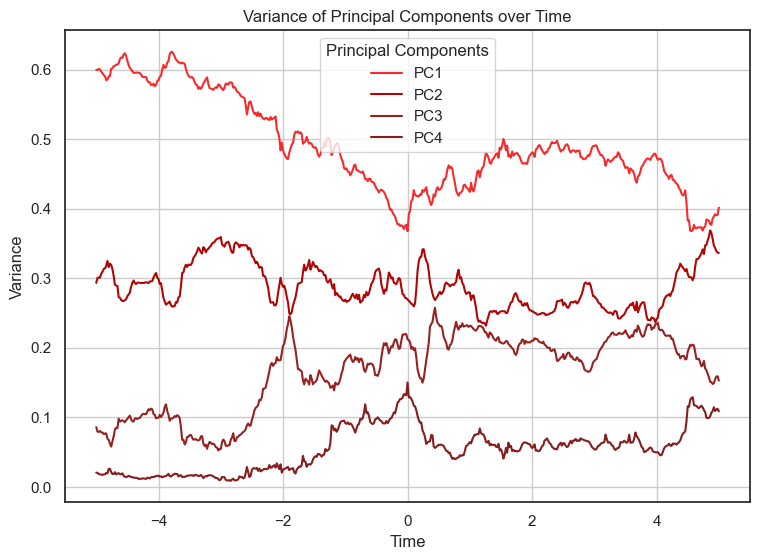

In [254]:
import matplotlib.pyplot as plt

# Example color palette you provided
color_pca = {
    'PC1': '#F72B2B', 'PC2': '#B10606',
    'PC3': '#962222', 'PC4': '#851E1E',
    'PC5': '#641717', 'PC6': '#430F0F',
    'PC7': '#3A0E0E', 'PC8': '#320C0C',
    'PC9': '#2B0A0A', 'PC10': '#240808',
    'PC11': '#1D0707', 'PC12': '#160505',
    'PC13': '#100303', 'PC14': '#0A0202',
    # 'PC15': '#050101'
}

# Select PCs to plot
pcs = ['PC1', 'PC2', 'PC3', 'PC4']#, 'PC5']

plt.figure(figsize=(8, 6))

for pc in pcs:
    plt.plot(variances_df['Time'], variances_df[pc], label=pc, color=color_pca.get(pc, '#000000'))

plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Variance of Principal Components over Time')
plt.legend(title='Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()